In [1]:
import numpy as np
import mne
from pathlib import Path
import neural_mi as nmi
import os
import torch
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
os.environ["NMI_DISABLE_CACHE"] = "1"   # disable caching
os.environ["NMI_CACHE_DIR"] = "./tmp"   # small local dir

In [22]:
import numpy as np
import mne
from pathlib import Path

# ----------------- CONFIG ----------------- #
DATA_FOLDER = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
OUT_AUD_FILE = Path("../data/processed/P1_all_subjects_auditory_epochs.npy")
OUT_TAC_FILE = Path("../data/processed/P1_all_subjects_tactile_epochs.npy")

SUBJECT_IDS = [x for x in range(2, 18) if x not in (4, 14)]
SET_TEMPLATE = "binepochs filtered ICArej P1AvgBOS{num}.set"

APPLY_BANDPASS = True
BANDPASS = (1.0, 30.0)
BASELINE = (None, 0.0)
# ------------------------------------------ #

def preprocess_epochs(epochs):
    """Applies baseline, filtering, and z-scoring per epoch."""
    if BASELINE is not None:
        epochs.apply_baseline(BASELINE)
    data = epochs.get_data()  # (n_epochs, n_channels, n_times)
    sfreq = epochs.info["sfreq"]

    # Apply 1–30 Hz bandpass filter if requested
    if APPLY_BANDPASS:
        for e in range(len(data)):
            data[e] = mne.filter.filter_data(
                data[e],
                sfreq,
                l_freq=BANDPASS[0],
                h_freq=BANDPASS[1],
                verbose=False,
            )

    # Z-score per epoch, channel-wise
    for e in range(len(data)):
        means = data[e].mean(axis=1, keepdims=True)
        stds = data[e].std(axis=1, keepdims=True)
        stds[stds == 0] = 1.0
        data[e] = (data[e] - means) / stds

    return data, sfreq


# ------------- MAIN LOOP ------------- #
auditory_all = []
tactile_all = []
common_ch_names = None
sfreq = None

for subj in SUBJECT_IDS:
    fname = SET_TEMPLATE.format(num=subj)
    set_path = DATA_FOLDER / fname
    if not set_path.exists():
        print(f"Skipping missing subject {subj}")
        continue

    print(f"Processing subject {subj}...")

    epochs = mne.io.read_epochs_eeglab(set_path)
    if common_ch_names is None:
        common_ch_names = epochs.ch_names
    else:
        assert epochs.ch_names == common_ch_names, f"Channel mismatch in subject {subj}!"

    # Split into auditory and tactile trials
    auditory_epochs = epochs[::2]
    tactile_epochs = epochs[1::2]

    aud_data, sfreq = preprocess_epochs(auditory_epochs)
    tac_data, _ = preprocess_epochs(tactile_epochs)

    auditory_all.append(aud_data)
    tactile_all.append(tac_data)

# --- Concatenate across subjects (along epoch dimension) ---
auditory_grand = np.concatenate(auditory_all, axis=0)
tactile_grand = np.concatenate(tactile_all, axis=0)

print(f"Auditory grand shape: {auditory_grand.shape}")  # (total_epochs, n_channels, n_times)
print(f"Tactile grand shape:  {tactile_grand.shape}")

# --- Save outputs ---
np.save(OUT_AUD_FILE, auditory_grand)
np.save(OUT_TAC_FILE, tactile_grand)

print(f"Saved auditory data to {OUT_AUD_FILE}")
print(f"Saved tactile data to  {OUT_TAC_FILE}")

# --- Optional: Save metadata ---
meta_info = {
    "ch_names": common_ch_names,
    "sfreq": sfreq,
    "BANDPASS": BANDPASS,
    "BASELINE": BASELINE,
    "SUBJECT_IDS": SUBJECT_IDS,
}
np.save("../data/processed/meta_info.npy", meta_info, allow_pickle=True)
print("Saved metadata to ../data/processed/meta_info.npy")


Processing subject 2...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Processing subject 3...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS3.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 5...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS5.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 6...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS6.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 7...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS7.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 8...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS8.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 9...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS9.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 10...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS10.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 11...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS11.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 12...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS12.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 13...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS13.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 15...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS15.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 16...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS16.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Processing subject 17...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS17.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\2998235655.py:61: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Auditory grand shape: (840, 32, 1792)
Tactile grand shape:  (840, 32, 1792)


OSError: [Errno 22] Invalid argument: '..\\data\\processed\\P1_all_subjects_tactile_epochs.npy'

In [20]:
aud = np.load("../data/processed/P1_all_subjects_auditory_epochs.npy")
tac = np.load("../data/processed/P1_all_subjects_tactile_epochs.npy", mmap_mode='r')
meta = np.load("../data/processed/meta_info.npy", allow_pickle=True).item()

print(aud.shape)  # (N_total_epochs, 32, 1792)
print(meta["ch_names"])


data_path = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
file_path = data_path / "binepochs filtered ICArej P1AvgBOS2.set"
epochs = mne.io.read_epochs_eeglab(file_path)

(840, 32, 1792)
['AF7', 'FPZ', 'AF8', 'AF3', 'AF4', 'F3', 'FZ', 'F4', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP7', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'POz', 'O1', 'Oz', 'O2']
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25800\1728175681.py:11: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


In [23]:
ch_names = epochs.ch_names
sel = [ch_names.index(ch) for ch in ['T7', 'T7']]
selected_1 = data[sel, :]
x = selected_1[0, :30_000].reshape(1, -1)
y = selected_1[1, :30_000].reshape(1, -1)
print(selected_1[0].reshape(1,-1).shape)
print(x.shape)
print(y.shape)

(1, 1505280)
(1, 30000)
(1, 30000)


x: (1, 30000) y: (1, 30000)
Overlap correlation: 1.0


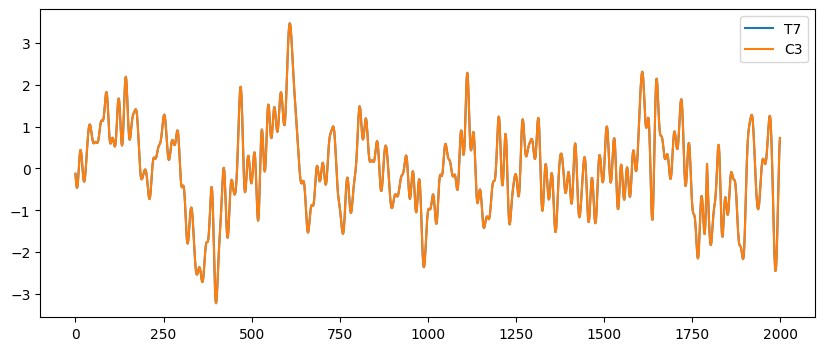

In [13]:
import numpy as np

print("x:", x.shape, "y:", y.shape)
print("Overlap correlation:", np.corrcoef(x.flatten(), y.flatten())[0,1])

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(x[0, :2000], label='T7')
plt.plot(y[0, :2000], label='C3')
plt.legend()
plt.show()


In [5]:
SWEEP_GRID = {'critic_type': ['separable'], 'run_id': range(2)}

BASE_PARAMS = {
    'n_epochs': 30,
    'learning_rate': 1e-3,
    'batch_size': 32,
    'embedding_dim': 8,
    'hidden_dim': 32,
    'n_layers': 2,
    'patience': 20, # consider increasing patience for real analyses
}

In [29]:
# Clear cuda cache
torch.cuda.empty_cache()

In [ ]:
results = nmi.run(
    x_data=x,
    y_data=y,
    mode='lag',
    processor_type_x='continuous',
    processor_type_y='continuous',
    processor_params={'window_size': 500},
    base_params=BASE_PARAMS,
    sweep_grid=SWEEP_GRID,
    lag_range=range(-100, 101, 20),
    n_workers=1,
)

In [16]:
# assume x, y are 1D numpy arrays, sfreq defined
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import neural_mi as nmi

# windowing params
win_s = 0.5
win = int(win_s * sfreq)
step = win  # non-overlap

def make_windows(signal, win_len, step):
    starts = np.arange(0, len(signal) - win_len + 1, step)
    return np.stack([signal[s:s+win_len] for s in starts], axis=0)

Xw = make_windows(x, win, step)
Yw = make_windows(y, win, step)

# STANDARDIZE PER WINDOW (rows) — CORRECT METHOD
Xw = (Xw - Xw.mean(axis=1, keepdims=True)) / (Xw.std(axis=1, keepdims=True) + 1e-12)
Yw = (Yw - Yw.mean(axis=1, keepdims=True)) / (Yw.std(axis=1, keepdims=True) + 1e-12)

# Subsample windows if needed
maxwins = 500
Xw = Xw[:maxwins]
Yw = Yw[:maxwins]

# Shuffle rows for control
rng = np.random.RandomState(42)
idx = rng.permutation(Yw.shape[0])
Yw_shuf = Yw[idx]

# small conservative model
base_params = {
    'n_epochs': 40, 'learning_rate': 5e-4, 'batch_size': 32,
    'patience': 8, 'embedding_dim': 8, 'hidden_dim': 32, 'n_layers': 1
}
sweep_grid = {'critic_type': ['separable']}
lag_range = range(-250, 251, 25)

res = nmi.run(
    x_data=Xw, y_data=Yw,
    mode='lag',
    processor_type_x='continuous', processor_params_x={'window_size':1},
    processor_type_y='continuous', processor_params_y={'window_size':1},
    base_params=base_params, sweep_grid=sweep_grid,
    lag_range=lag_range, split_mode='random', n_workers=1, random_seed=42
)

res_shuf = nmi.run(
    x_data=Xw, y_data=Yw_shuf,
    mode='lag',
    processor_type_x='continuous', processor_params_x={'window_size':1},
    processor_type_y='continuous', processor_params_y={'window_size':1},
    base_params=base_params, sweep_grid=sweep_grid,
    lag_range=lag_range, split_mode='random', n_workers=1, random_seed=42
)

# plot
lags = res.details.get('lags', np.arange(len(res.details['mi_curve'])))
plt.plot(lags, res.details['mi_curve'], label='orig')
plt.plot(lags, res_shuf.details['mi_curve'], label='shuffled', ls='--')
plt.legend(); plt.title('MI vs lag (corrected preprocessing)'); plt.show()



2025-11-03 17:03:49 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-03 17:03:49 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-03 17:03:49 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

Run lag-250_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-225_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-200_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-175_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-150_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-125_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-100_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-75_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag75_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag100_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag125_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag150_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag175_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag200_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag225_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag250_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

2025-11-03 17:04:08 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-03 17:04:08 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-03 17:04:08 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

Run lag-250_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-225_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-200_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-175_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-150_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-125_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-100_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-75_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag75_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag100_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag125_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag150_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag175_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag200_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag225_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

Run lag250_combo0:   0%|          | 0/40 [00:00<?, ?it/s]

KeyError: 'mi_curve'

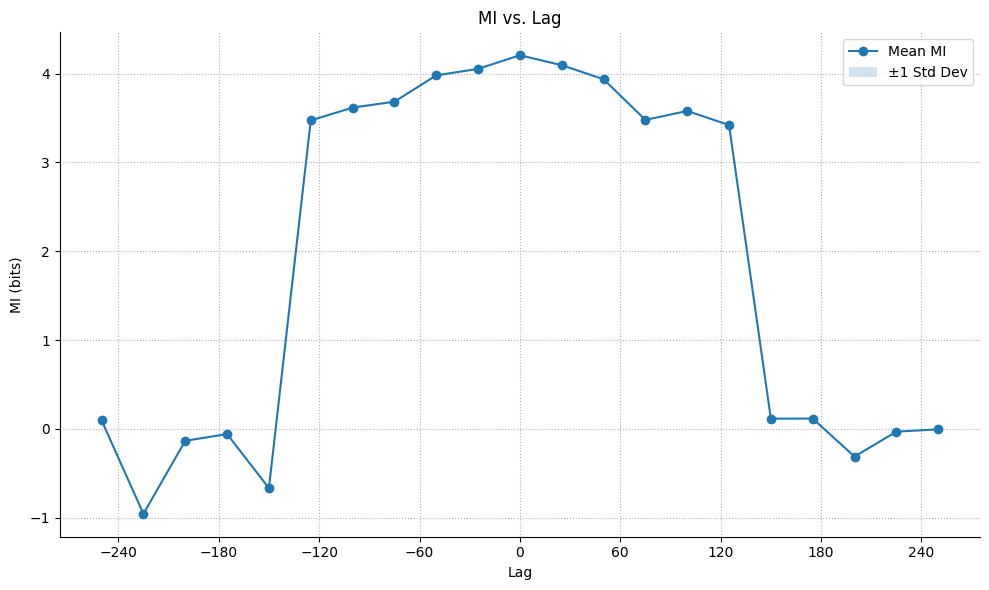

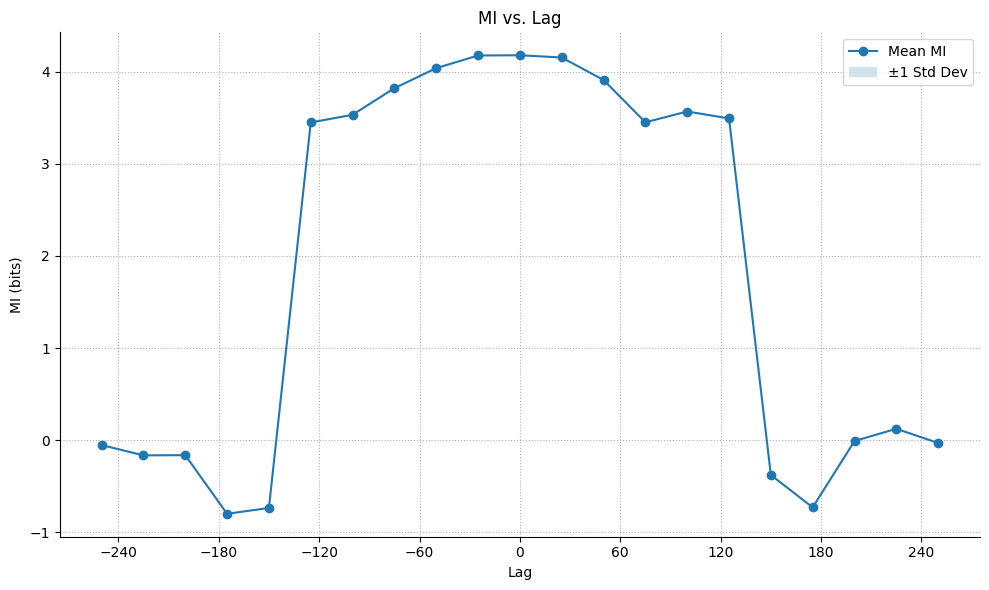

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [17]:
res.plot(show=True)
res_shuf.plot(show=True)

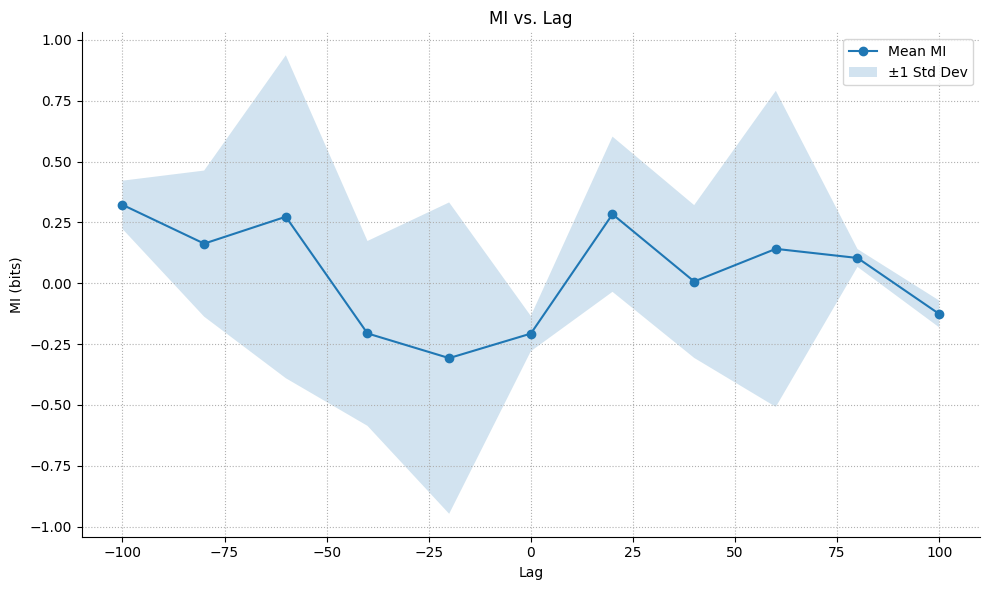

In [12]:
ax = results.plot(show=True)

In [8]:
lag_range = range(-100, 101, 20)
window_range = list(range(225, 550, 25))
mi_results_2d = []

print("Starting 2D sweep...")
for lag in tqdm(lag_range, desc="Lag Sweep Progress"):
    results = nmi.run(
        x_data=x,
        y_data=y,
        mode='sweep',
        processor_type_x='continuous',
        processor_type_y='continuous',
        processor_params_x={},
        processor_params_y={},
        base_params=BASE_PARAMS,
        sweep_grid={'window_size': window_range},
        n_workers=2,
        verbose=False
    )

    for _, row in results.dataframe.iterrows():
        mi_results_2d.append({
            'lag': lag, 
            'window_size': row['window_size'],
            'mi': row['mi_mean']
        })

print("2D sweep complete!")
results_df_2d = pd.DataFrame(mi_results_2d)

Starting 2D sweep...


Lag Sweep Progress:   0%|          | 0/11 [00:00<?, ?it/s]

2025-11-01 13:27:54 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 13:27:54 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 13:55:57 - neural_mi - INFO - Parameter sweep finished.
2025-11-01 13:55:58 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 13:55:58 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 14:23:08 - neural_mi - INFO - Parameter sweep finished.
2025-11-01 14:23:08 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 14:23:08 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 14:48:49 - neural_mi - INFO - Parameter sweep finished.
2025-11-01 14:48:49 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 14:48:49 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 15:13:01 - neural_mi - INFO - Parameter sweep finished.
2025-11-01 15:13:01 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 15:13:01 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 15:37:18 - neural_mi - INFO - Parameter sweep finished.
2025-11-01 15:37:18 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 15:37:18 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 16:01:07 - neural_mi - INFO - Parameter sweep finished.
2025-11-01 16:01:07 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 16:01:07 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 16:26:32 - neural_mi - INFO - Parameter sweep finished.
2025-11-01 16:26:32 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 16:26:32 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 16:52:35 - neural_mi - INFO - Parameter sweep finished.
2025-11-01 16:52:35 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 16:52:35 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 17:19:42 - neural_mi - INFO - Parameter sweep finished.
2025-11-01 17:19:42 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 17:19:42 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 17:44:52 - neural_mi - INFO - Parameter sweep finished.
2025-11-01 17:44:52 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-01 17:44:52 - neural_mi - INFO - Starting parameter sweep with 2 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-11-01 18:09:48 - neural_mi - INFO - Parameter sweep finished.
2D sweep complete!


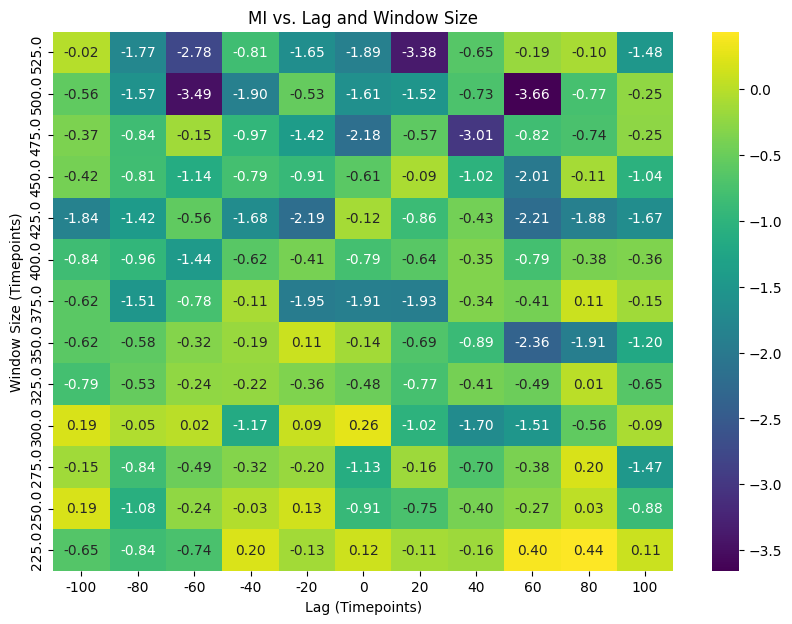

In [9]:
# Pivot the data for the heatmap
heatmap_data = results_df_2d.pivot(index='window_size', columns='lag', values='mi')

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('MI vs. Lag and Window Size')
plt.xlabel('Lag (Timepoints)')
plt.ylabel('Window Size (Timepoints)')
plt.gca().invert_yaxis()
plt.show()

In [14]:
sweep_grid = {
    'critic_type': ['separable', 'bilinear', 'concat'],
    'run_id': range(5) # Average over 5 runs for stability
}

base_params = {
    'n_epochs': 100, 'learning_rate': 5e-4, 'batch_size': 64,
    'patience': 20, 'embedding_dim': 8, 'hidden_dim': 64, 'n_layers': 3
}

# Run lag analysis with window fixed at 500ms comparing separable vs. bilinear critic types, using cnn embedding model
# Sanity check with x vs. x
results_1 = nmi.run(
    x_data=x,
    y_data=x,
    mode='sweep', 
    processor_type_x='continuous',
    processor_type_y='continuous',
    processor_params={'window_size': 1000},
    base_params=base_params,
    sweep_grid=sweep_grid,
    lag_range=range(-400, 400, 20),
    n_workers=1
)

2025-11-03 15:30:52 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-11-03 15:30:52 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c0:   0%|          | 0/100 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c1:   0%|          | 0/100 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c2:   0%|          | 0/100 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c3:   0%|          | 0/100 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c4:   0%|          | 0/100 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c5:   0%|          | 0/100 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c6:   0%|          | 0/100 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c7:   0%|          | 0/100 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c8:   0%|          | 0/100 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c9:   0%|          | 0/100 [00:00<?, ?it/s]

Run 80eb3b4e-2d0c-418a-8ff7-31b98a86b980_c10:   0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 198.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.42 GiB is allocated by PyTorch, and 24.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

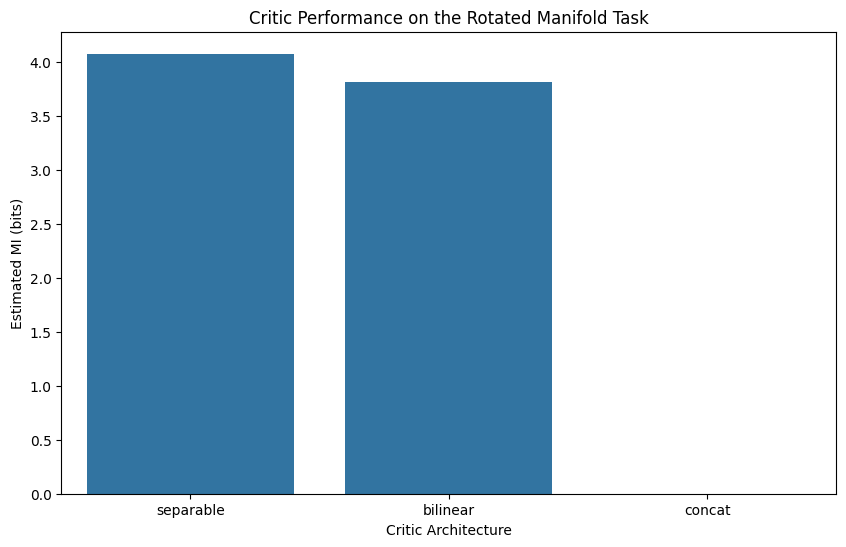

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_1.dataframe, x='critic_type', y='mi_mean', capsize=0.1, order=['separable', 'bilinear', 'concat'])
plt.title('Critic Performance on the Rotated Manifold Task')
plt.ylabel('Estimated MI (bits)')
plt.xlabel('Critic Architecture')
plt.ylim(bottom=0)
plt.show()